# Italy case study

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from helper import *
from scipy.stats.mstats import gmean
#Importation of all the packages
from datetime import datetime
import math
import json
import zipfile  
import ssl
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics

#To dowload data
import requests
import io
import gzip

#To create the mapchart
import iso3166
import plotly
from iso3166 import countries
import plotly.graph_objects as go
import plotly.express as px


import matplotlib.gridspec as gridspec
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

## Download COVID-19 data

In [85]:
# Download covid data
deaths, cases, deaths_cumul, cases_cumul, deaths100k, deaths100k_cumul, cases100k, cases100k_cumul = get_cases_deaths_df(population_df, get_country_dict('original'), '2020-01-22', '2022-07-31')

In [88]:
#getting dict of country name with countries language code
o_country_dict = get_country_dict('original')
inv_o_country_dict = {v: k for k, v in o_country_dict.items()}
other_country_name = {"Russia": "Russian Federation", "Turkey":"Türkiye", "Vietnam" : "Viet Nam", "South Korea" : "Korea, Democratic People's Republic of" }

In [91]:
deaths = deaths.rename(columns = inv_o_country_dict)
cases = cases.rename(columns = inv_o_country_dict)

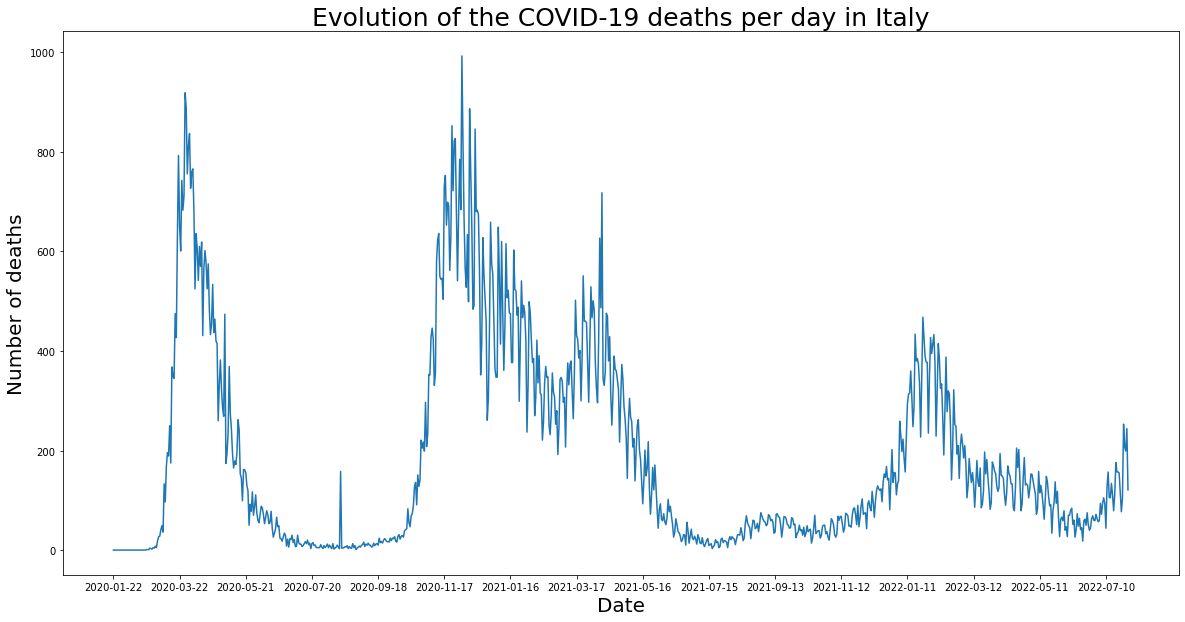

In [103]:
#Plot the evolution of the number of deaths per day in Italy
plt.figure(figsize=(20, 10))
plt.plot(deaths['Italy'])
plt.xlabel("Date",fontsize=20)
plt.ylabel("Number of deaths",fontsize=20)
plt.xticks(deaths.index[::60])
plt.title("Evolution of the COVID-19 deaths per day in Italy",fontsize=25)
plt.show()

                 trend   seasonal      resid  observed       date
date                                                             
2020-01-22         NaN  16.099717        NaN       0.0 2020-01-22
2020-01-23         NaN  16.486488        NaN       0.0 2020-01-23
2020-01-24         NaN  14.426049        NaN       0.0 2020-01-24
2020-01-25    0.000000  -6.479345   6.479345       0.0 2020-01-25
2020-01-26    0.000000 -50.865386  50.865386       0.0 2020-01-26
...                ...        ...        ...       ...        ...
2022-07-26  171.428571  32.911059  48.660370     253.0 2022-07-26
2022-07-27  172.142857  16.099717  18.757426     207.0 2022-07-27
2022-07-28         NaN  16.486488        NaN     199.0 2022-07-28
2022-07-29         NaN  14.426049        NaN     244.0 2022-07-29
2022-07-30         NaN  -6.479345        NaN     121.0 2022-07-30

[921 rows x 5 columns]


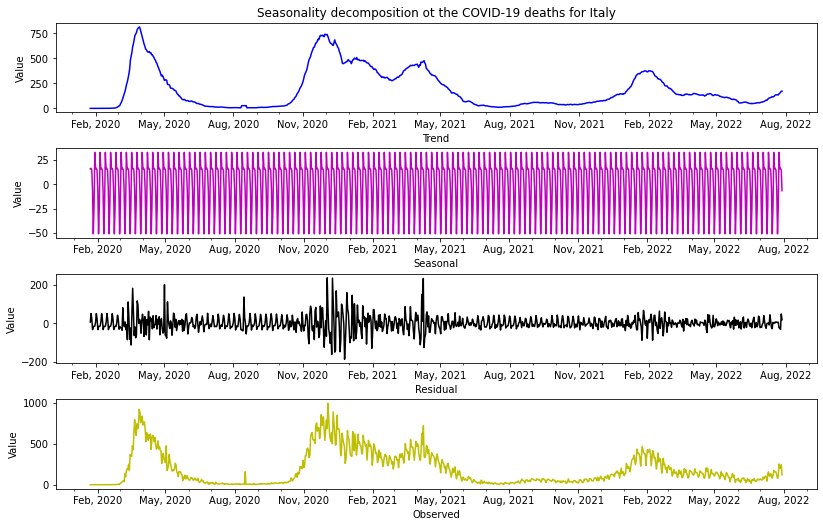

In [93]:
#Seasonality decomposition for pageviews time serie
fig = plt.figure(figsize=(30, 60)) 
outer = gridspec.GridSpec(6, 2, wspace=0.2, hspace=0.2)
inner = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[0], wspace=0.2, hspace=0.4)
seasonal_decomp(deaths['Italy'], 7,'Seasonality decomposition ot the COVID-19 deaths for Italy',fig,inner) 

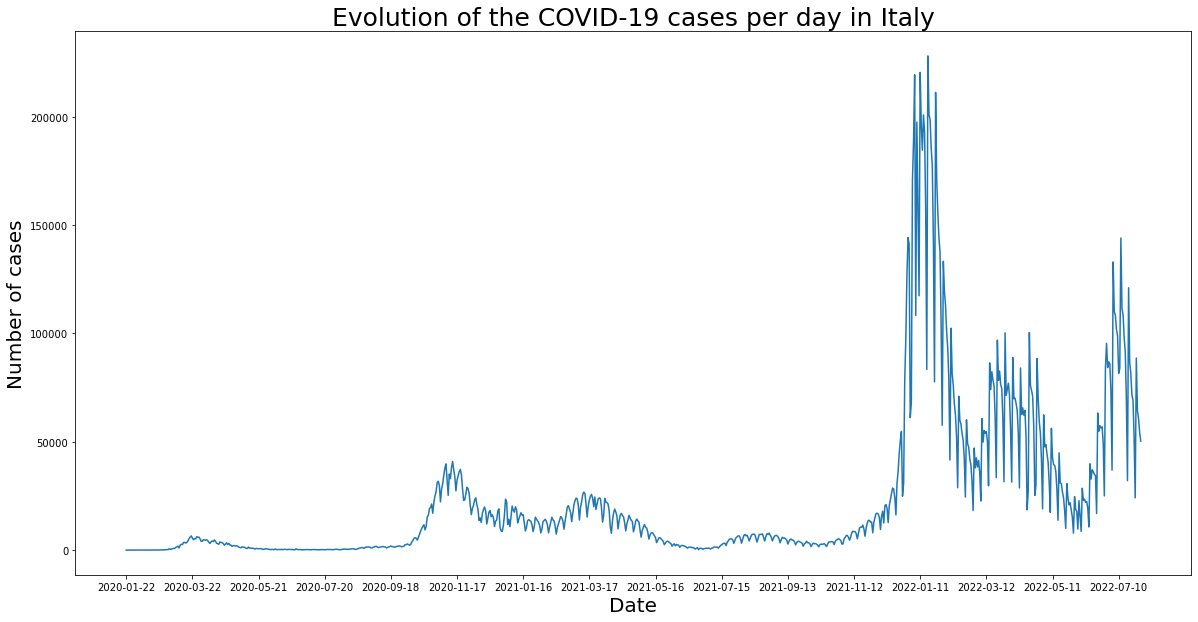

In [94]:
#Plot the evolution of the number of cases per day in Italy
plt.figure(figsize=(20, 10))
plt.plot(cases['Italy'])
plt.xlabel("Date",fontsize=20)
plt.ylabel("Number of cases",fontsize=20)
plt.xticks(deaths.index[::60])
plt.title("Evolution of the COVID-19 cases per day in Italy",fontsize=25)
plt.show()

## Download wikipedia COVID-19 related pageviews

In [30]:
#Loading raw df from csv file
pageview_df = pd.read_csv("page_views_covid_related.csv.gz")
population_df = pd.read_csv("Population_countries.csv")
#get cleaned dfs, cumulative df and per 100k of population dfs for pageviews, covid cases and deaths data 
df_pageviews, df_pageviews_cumul, df_pageviews100k, df_pageviews_cumul100k = get_pageviews_df(pageview_df, population_df, get_country_dict('original'), '2020-01-22', '2022-07-31')

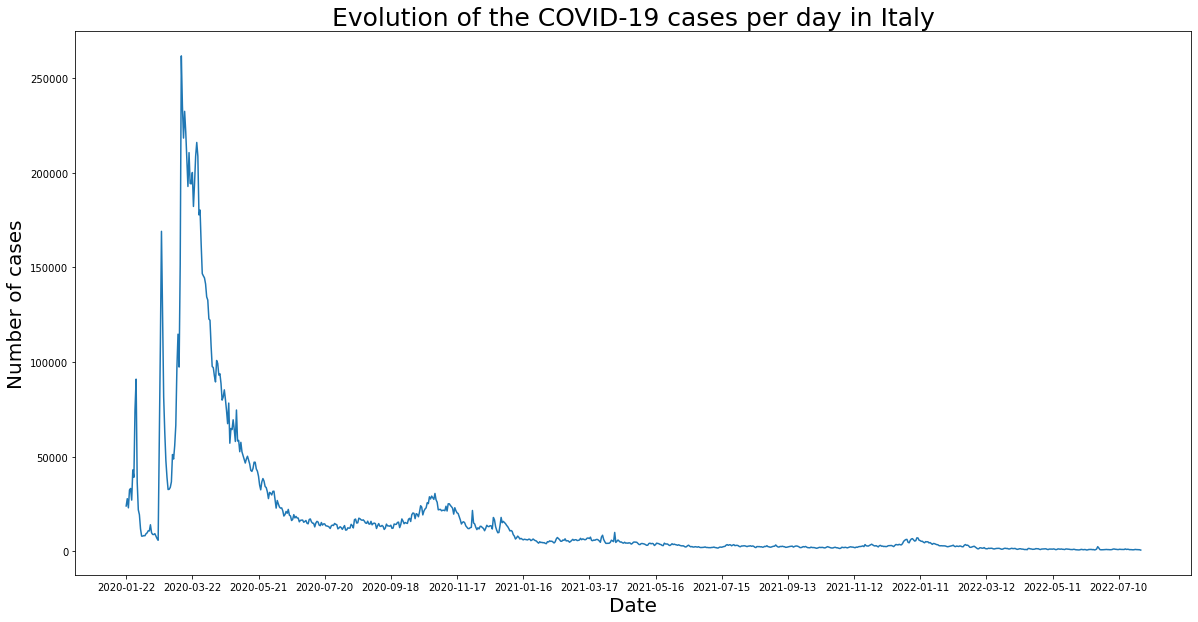

In [31]:
#Plot the evolution of the number of wikipedia covid-19 related pageviews per day in Italy
plt.figure(figsize=(20, 10))
plt.plot(df_pageviews['it'])
plt.xlabel("Date",fontsize=20)
plt.ylabel("Number of pageviews",fontsize=20)
plt.xticks(deaths.index[::60])
plt.title("Evolution of the wikipedia pageviews per day in Italy",fontsize=25)
plt.show()

In [70]:
#Seasonality decomposition of time series
def seasonal_decomp(df, freq, title, fig, inner):
    result = seasonal_decompose(df,model='additive', period=freq)
    results_df = pd.DataFrame({'trend': result.trend, 'seasonal': result.seasonal, 'resid': result.resid, 'observed': result.observed})
    results_df['date'] = results_df.index
    results_df['date'] = pd.to_datetime(results_df['date'])
    
    half_year_locator = mdates.MonthLocator(interval=3)
    month_year_formatter = mdates.DateFormatter('%b, %Y') 
    monthly_locator = mdates.MonthLocator()

    ax0 = plt.Subplot(fig, inner[0])
    ax0.plot(results_df['date'],results_df['trend'], 'b')
    ax0.set_title(title)
    ax0.set_xlabel('Trend')
    ax0.set_ylabel('Value')
    ax0.xaxis.set_major_locator(half_year_locator)
    ax0.xaxis.set_minor_locator(monthly_locator)
    ax0.xaxis.set_major_formatter(month_year_formatter)
    fig.add_subplot(ax0)

    ax1 = plt.Subplot(fig, inner[1])
    ax1.plot(results_df['date'], results_df['seasonal'], 'm')
    ax1.set_xlabel('Seasonal')
    ax1.set_ylabel('Value')
    ax1.xaxis.set_major_locator(half_year_locator)
    ax1.xaxis.set_minor_locator(monthly_locator)
    ax1.xaxis.set_major_formatter(month_year_formatter)
    fig.add_subplot(ax1)

    ax2 = plt.Subplot(fig, inner[2])
    ax2.plot(results_df['date'], results_df['resid'], 'k')
    ax2.set_xlabel('Residual')
    ax2.set_ylabel('Value')
    ax2.xaxis.set_major_locator(half_year_locator)
    ax2.xaxis.set_minor_locator(monthly_locator)
    ax2.xaxis.set_major_formatter(month_year_formatter)
    fig.add_subplot(ax2)

    ax3 = plt.Subplot(fig, inner[3])
    ax3.plot(results_df['date'], results_df['observed'], 'y')
    ax3.set_xlabel('Observed')
    ax3.set_ylabel('Value')
    ax3.xaxis.set_major_locator(half_year_locator)
    ax3.xaxis.set_minor_locator(monthly_locator)
    ax3.xaxis.set_major_formatter(month_year_formatter)
    fig.add_subplot(ax3)

                   trend    seasonal        resid  observed       date
date                                                                  
2020-01-22           NaN -457.496090          NaN   24011.0 2020-01-22
2020-01-23           NaN  469.960323          NaN   27869.0 2020-01-23
2020-01-24           NaN  462.865818          NaN   23035.0 2020-01-24
2020-01-25  30108.857143 -877.653124  3194.795981   32426.0 2020-01-25
2020-01-26  32275.285714  520.438480   453.275806   33249.0 2020-01-26
...                  ...         ...          ...       ...        ...
2022-07-26    947.714286 -368.797071   408.082785     987.0 2022-07-26
2022-07-27    926.571429 -457.496090   497.924661     967.0 2022-07-27
2022-07-28           NaN  469.960323          NaN     913.0 2022-07-28
2022-07-29           NaN  462.865818          NaN     906.0 2022-07-29
2022-07-30           NaN -877.653124          NaN     720.0 2022-07-30

[921 rows x 5 columns]


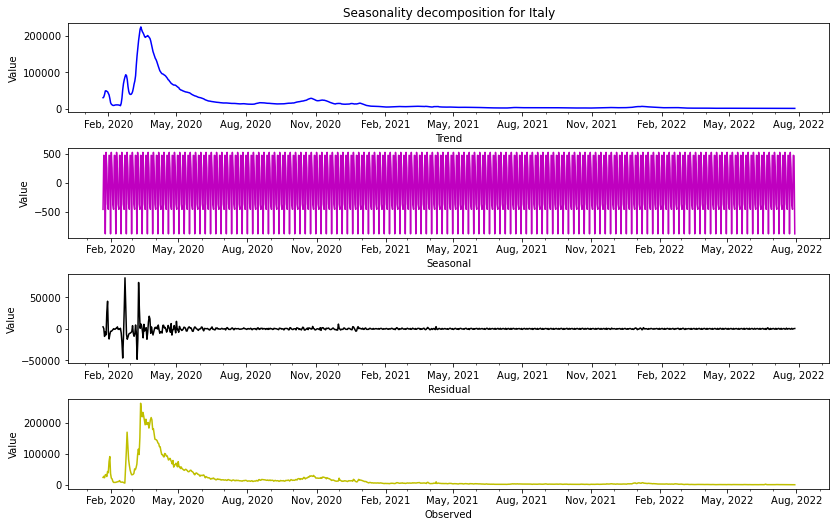

In [71]:
#Seasonality decomposition for pageviews time serie
fig = plt.figure(figsize=(30, 60)) 
outer = gridspec.GridSpec(6, 2, wspace=0.2, hspace=0.2)
inner = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[0], wspace=0.2, hspace=0.4)
seasonal_decomp(df_pageviews['it'], 7,'Seasonality decomposition for the page views time serie Italy',fig,inner) 

## Rolling correlation

,correlation,country
date,,
2020-04-30,236.573669,Italy
2020-05-01,236.753250,Italy
2020-05-02,235.229269,Italy
2020-05-03,235.412886,Italy
2020-05-04,235.491106,Italy
...,...,...
2022-07-26,9.947160,Italy
2022-07-27,9.741092,Italy
2022-07-28,9.527902,Italy


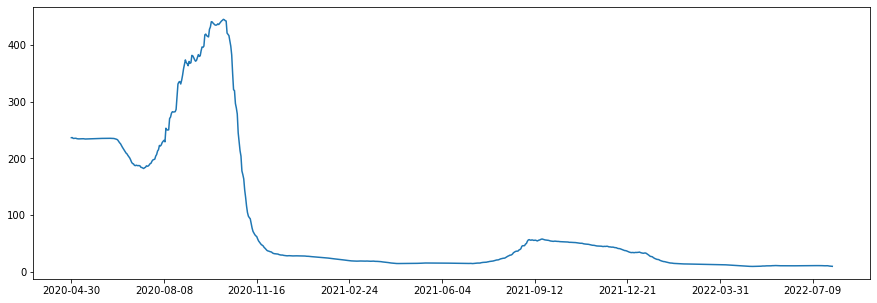

In [108]:
x = deaths['Italy']
y = df_pageviews['it']
model = RollingOLS(y,x, 100)
test = model.fit()
df = pd.DataFrame(test.params)

df = df.rename(columns = {'Italy' : 'correlation'})
df['country'] = 'Italy'

df = df.dropna(axis=0)
display(df)
    
plt.figure(figsize=(15, 5))   
plt.plot(df.index, df['correlation'])
plt.xticks(df.index[::100])
plt.show()

## Download the mobility data

In [ ]:
data_folder = 'data_2/'

#Download mobility and intervention files
google_mobility = pd.read_csv(data_folder+'Global_Mobility_Report.csv.zip')

In [6]:
#Change name of the columns
categories = ["Retail and Recreations", "Grocery and Pharmacy", "Parks","Transit stations", "Workplace", "Residential"]
google_mobility = google_mobility.rename(dict(zip(google_mobility.columns[8:],categories)), axis = 1)

#Transform date string to datetime
google_mobility['date'] = pd.to_datetime(google_mobility['date'])

#Delete columns about region
google_mobility = google_mobility.drop(google_mobility.iloc[:,2:7], axis = 1)

#Keep date from the 22nd January 2020 to the 31st July 2020
google_mobility = google_mobility.loc[(google_mobility['date'] < "2020-08-01") & (google_mobility['date'] >= "2020-01-22")]

#Regroup all data per country and per date and take the average
mobility = google_mobility.groupby(["country_region_code","country_region","date"]).mean()

#Keep only the country from our analysis
mobility = mobility[mobility.index.get_level_values('country_region').isin(list(get_country_dict('original').keys()))]

<ipython-input-6-de6d26abe512>:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  google_mobility = pd.read_csv(data_folder+'Global_Mobility_Report.csv.zip')


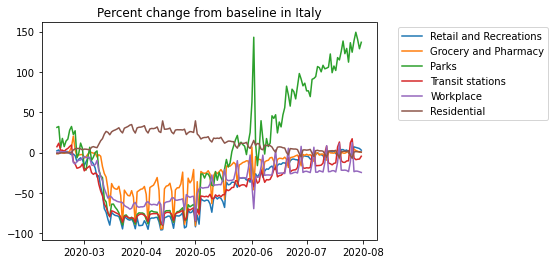

In [12]:
#Plot the mobility values for each category for Italy
for cat in categories:
        data = mobility[mobility.index.get_level_values('country_region')=='Italy']
        plt.plot(data.index.get_level_values('date'),data[cat], label = cat)
plt.title("Percent change from baseline in Italy")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [102]:
pearson_deaths = pd.DataFrame({"Pearson correlation":["Correlation coefficient:","P-value:"]})

for country in get_country_dict('original').items():
    corr, p_value = stats.pearsonr(df_pageviews[country[1]], deaths[country[0]])
    output_df = pd.DataFrame({str(country[0]):[corr, p_value] })
    pearson_deaths = pd.concat([pearson_deaths, output_df], axis=1)
print("{:.4f}".format(pearson_deaths['Italy'][0]))

-0.1474


In [99]:
pearson_cases = pd.DataFrame({"Pearson correlation":["Correlation coefficient:","P-value:"]})

for country in get_country_dict('original').items():
    corr, p_value = stats.pearsonr(df_pageviews[country[1]], cases[country[0]])
    output_df = pd.DataFrame({str(country[0]):[corr, p_value] })
    pearson_cases = pd.concat([pearson_cases, output_df], axis=1)
print("{:.4f}".format(pearson_cases['Italy'][0]))

-0.1999


In [77]:
# Dowload and preprocess trust dataset
data_folder = 'data_2/'
df_trust_gov = pd.read_csv(data_folder+'share-who-trust-government.csv.zip') 
df_trust_gov = df_trust_gov.set_index("Entity")[["Trust the national government in this country"]].transpose()[COUNTRY_OWN_LANG_TRUST_GOV.keys()].rename(columns= COUNTRY_OWN_LANG_TRUST_GOV)
country_dict = get_country_dict('trust gov mobility')

In [80]:
df_trust_gov['it'] 

Trust the national government in this country    52.3
Name: it, dtype: float64

### ITALY INFORMATIONS

First case : 2020-01-31
First death : 2020-02-22
Lockdown : 2020-03-11

##### Trust = 52.3
##### Correlation with deaths = 0.3486
##### Correlation with cases = -0.1999

#### PIB/hab = 51,062 dollars
#### Population estimated in 2022 = 58,853,482
#### Government = Unitary parliamentary republic